In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


For this task, I decided to use a new dataset obtained by generating MACCS fingerprints. I decided this because the previous dataset containing descriptors from **various** libraries showed poor results, for example, in a task with clustering. That is why I repeat some steps in order to get a new clean dataset

In [5]:
# Load initial dataset
df = pd.read_csv(r"vepreva_dataset.csv", usecols=[2,10])
df.head(5)

,smiles,gap
0,C1OC11CC2CCC2C1,0.3261
1,CCC(C)C1=CN=NO1,0.2341
2,CC1OC1C1NCC1=O,0.2200
3,NC(=O)C12CC1C1CN21,0.2488
4,C1C2CC(C12)N1CC1,0.3210


In [6]:
smiles = df['smiles'].to_list()

In [9]:
# Converting smiles to MACCS fingerprints
mols = [Chem.MolFromSmiles(i) for i in smiles]
MACCS_list = []
header = ['bit' + str(i) for i in range(167)]
for i in range(len(mols)):
    ds = list(MACCSkeys.GenMACCSKeys(mols[i]).ToBitString())
    MACCS_list.append(ds)
df2 = pd.DataFrame(MACCS_list,columns=header)
df2.insert(loc=0, column='smiles', value=smiles)

In [10]:
df2.head(5)

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit157,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166
0,C1OC11CC2CCC2C1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
1,CCC(C)C1=CN=NO1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,1,0
2,CC1OC1C1NCC1=O,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,0,0,1,1,0
3,NC(=O)C12CC1C1CN21,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,1,1,1,0
4,C1C2CC(C12)N1CC1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


In [12]:
df3 = pd.concat([df2, df['gap']], axis = 1)
df3.head(5)

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166,gap
0,C1OC11CC2CCC2C1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0.3261
1,CCC(C)C1=CN=NO1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,1,1,0,0.2341
2,CC1OC1C1NCC1=O,0,0,0,0,0,0,0,0,1,...,1,1,1,1,0,0,1,1,0,0.2200
3,NC(=O)C12CC1C1CN21,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,1,1,1,0,0.2488
4,C1C2CC(C12)N1CC1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0.3210


In [13]:
# Let's check the number of gaps in the various columns
df3.isnull().values.any()

False

In [14]:
# Removing complete duplicates
df3 = df3.drop_duplicates()

Deleting outliers

In [18]:
def detect_outliers_zscore(data, threshold=3.0):
    """
    Detect outliers using Z-score method.

    Parameters:
        data (array-like): Input data.
        threshold (float): Z-score threshold for identifying outliers.

    Returns:
        outliers (array-like): Array containing the indices of outlier data points.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(x - mean) / std_dev for x in data]
    outliers = np.where(np.abs(z_scores) > threshold)[0]
    return outliers

# Example usage:
outliers = detect_outliers_zscore(df3['gap'])
print("Indices of outliers:", outliers)
print("Outlier values:", [df3['gap'][i] for i in outliers])

Indices of outliers: [  220  1320  3462  4641  6324  7139  7888  8192 10072 11026 11350 13163
 13303 13306 13427 15114 15972 17110 17845 18689]
Outlier values: [0.06, 0.4298, 0.0814, 0.1021, 0.105, 0.1065, 0.4063, 0.3957, 0.6221, 0.0772, 0.4056, 0.042, 0.3939, 0.1026, 0.0246, 0.0787, 0.0966, 0.1085, 0.0821, 0.4109]


In [19]:
filtered_data = df3.drop(outliers)
filtered_data

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166,gap
0,C1OC11CC2CCC2C1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0.3261
1,CCC(C)C1=CN=NO1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,1,1,0,0.2341
2,CC1OC1C1NCC1=O,0,0,0,0,0,0,0,0,1,...,1,1,1,1,0,0,1,1,0,0.2200
3,NC(=O)C12CC1C1CN21,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,1,1,1,0,0.2488
4,C1C2CC(C12)N1CC1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0.3210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,c1(=O)c(nonc1N)N,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,0.1459
19996,O=CC12OC3CC1OC23,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,1,0,0.2022
19997,CC1OC(C)C1CC=O,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,1,0,0.2208
19998,N=COCC1CN1C=O,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,1,1,0,0.2481


In [23]:
X = filtered_data.iloc[:, 1:-1]
y = filtered_data['gap']

In [27]:
X.dtypes

bit0      object
bit1      object
bit2      object
bit3      object
bit4      object
           ...  
bit162    object
bit163    object
bit164    object
bit165    object
bit166    object
Length: 167, dtype: object

In [28]:
y.dtypes

dtype('float64')

In [29]:
# Converting object to float
object_columns = X.select_dtypes(include=['object']).columns

for col in object_columns:
    try:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    except ValueError:
        print(f"Could not convert column '{col}' to float")

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19980 entries, 0 to 19999
Columns: 167 entries, bit0 to bit166
dtypes: int64(167)
memory usage: 25.6 MB


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

In [39]:
model1 = lgb.LGBMRegressor(random_state=2024,
                          verbose=-1
                          )

model1.fit(X_train,
          y_train
          )

LGBMRegressor(random_state=2024, verbose=-1)

In [44]:
y_pred1 = model1.predict(X_test)

r2_initial_lgbm = r2_score(y_test,
                      y_pred1)

In [45]:
r2_initial_lgbm

0.9011024793193829

In [50]:
model2 = GradientBoostingRegressor(random_state=2024)

model2.fit(X_train,
          y_train
          )

GradientBoostingRegressor(random_state=2024)

In [51]:
y_pred2 = model2.predict(X_test)

r2_initial_gb = r2_score(y_test,
                      y_pred2)

In [52]:
r2_initial_gb

0.8488095747921552

In [54]:
model3 = DecisionTreeRegressor(random_state=2024)

model3.fit(X_train,
          y_train
          )

DecisionTreeRegressor(random_state=2024)

In [55]:
y_pred3 = model3.predict(X_test)

r2_initial_dt = r2_score(y_test,
                      y_pred3)

In [56]:
r2_initial_dt

0.8232688975688642

Let's visualize results via R2 plot

Text(0.1161, 0.36277658925345774, '$R^2=0.9011$')

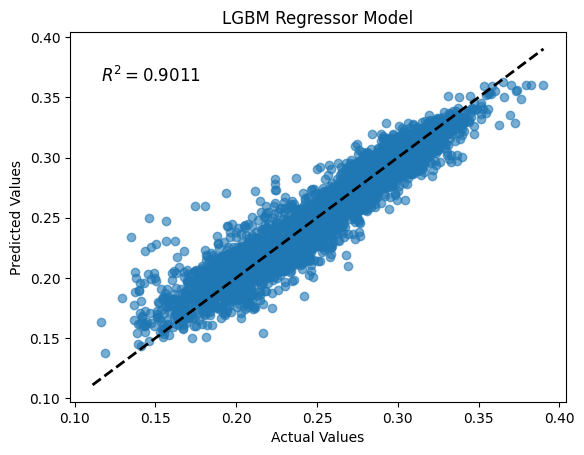

In [66]:
# LGBM regressor model

plt.scatter(y_test, y_pred1, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'LGBM Regressor Model')
plt.text(np.min(y_test), np.max(y_pred1), f'$R^2={r2_initial_lgbm:.4f}$', fontsize=12)


Text(0.1161, 0.32837212239435987, '$R^2=0.8488$')

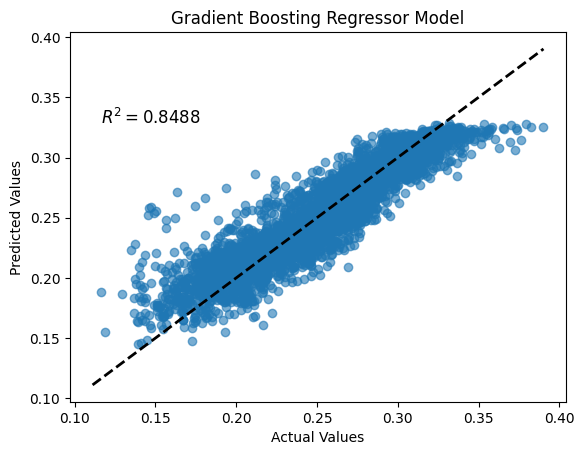

In [72]:
# Gradient Boosting Regressor regressor model

plt.scatter(y_test, y_pred2, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Gradient Boosting Regressor Model')
plt.text(np.min(y_test), np.max(y_pred2), f'$R^2={r2_initial_gb:.4f}$', fontsize=12)

Text(0.1161, 0.3854, '$R^2=0.8233$')

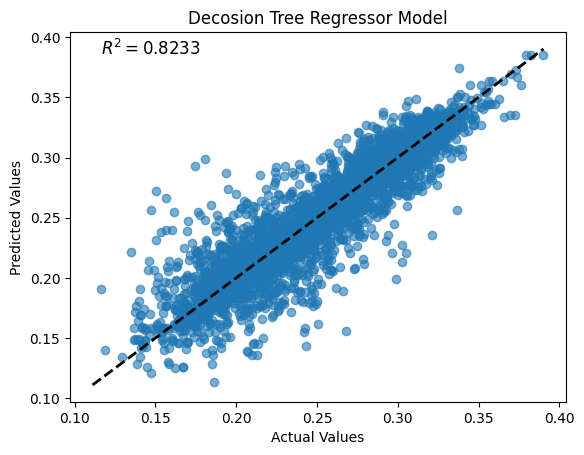

In [71]:
# Decision Tree Regressor regressor model

plt.scatter(y_test, y_pred3, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Decosion Tree Regressor Model')
plt.text(np.min(y_test), np.max(y_pred3), f'$R^2={r2_initial_dt:.4f}$', fontsize=12)

So, LGBM Regressor shows the best performance

Let's compare training speed

In [78]:
import time

# LGBM Model
start_time = time.time()

model1.fit(X_train, y_train)

training_time1 = time.time() - start_time

# Gradient Boosting Model
start_time = time.time()

model2.fit(X_train, y_train)

training_time2 = time.time() - start_time

# Decision Tree Model
start_time = time.time()

model3.fit(X_train, y_train)

training_time3 = time.time() - start_time


print("Training time for Model 1:", training_time1)
print("Training time for Model 2:", training_time2)
print("Training time for Model 3:", training_time3)

Training time for Model 1: 0.1550002098083496
Training time for Model 2: 2.8067033290863037
Training time for Model 3: 0.32471585273742676


So, the best trainig speed is observed for LGBM Regressor

Let's optimize parameters for LGBM model

In [75]:
param_grid = {'num_leaves': [10, 25, 40],
              'reg_alpha': [0.1, 0.25, 0.5],
              'min_data_in_leaf': [5, 10, 15],
              'learning_rate': [0.01, 0.05, 0.1],
              'num_estimators': [50, 100]
              } 

grid = GridSearchCV(estimator=model1,
                    param_grid=param_grid,
                    cv=10,
                    scoring='neg_root_mean_squared_error',
                    verbose=0
                    ) 

grid.fit(X_train,
         y_train
         )

GridSearchCV(cv=10, estimator=LGBMRegressor(random_state=2024, verbose=-1),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'min_data_in_leaf': [5, 10, 15],
                         'num_estimators': [50, 100],
                         'num_leaves': [10, 25, 40],
                         'reg_alpha': [0.1, 0.25, 0.5]},
             scoring='neg_root_mean_squared_error')

In [76]:
optimized_model = grid.best_estimator_ # We take the best hyperparameters set for later use
y_pred_optimized = optimized_model.predict(X_test)
r2_optimized = r2_score(y_test,
                        y_pred_optimized
                        )

In [77]:
r2_optimized

0.9026246510068606